In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
features = "polar"
lag = "0"
model_save_dir = os.getcwd() + f"/ml-models/{features}-lag{lag}/"

In [4]:
def loadNpy(filename):
    with open(os.getcwd() + "/train-val-test/"+ filename, "rb") as f: return np.load(f)

db = f"db14/window-size-10/lag{lag}/{features}-features/"
data_type = ""

In [5]:
DIR = os.getcwd() + "/train-val-test/" + db

In [6]:
X_train, X_val, X_test = loadNpy(db + f"X_train.npy"), loadNpy(db + f"X_val.npy"), loadNpy(db + f"X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"y{data_type}_train.npy"), loadNpy(db + f"y{data_type}_val.npy"), loadNpy(db + f"y{data_type}_test.npy")

In [7]:
def npy_to_tensor(data, l=False):
    if not l:
        data = torch.from_numpy(data).float()
    else:
        data = torch.from_numpy(data).type(torch.LongTensor)
    return data

In [8]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train,1), npy_to_tensor(y_val,1), npy_to_tensor(y_test,1)

In [9]:
batch_size = 128

In [10]:
train_dataset = TensorDataset(X_train, y_train)

val_dataset = TensorDataset(X_val, y_val)

test_dataset = TensorDataset(X_test, y_test)

# Data loader
train_iterator = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

In [11]:
torch.save(train_dataset, DIR + "train-dataset")
torch.save(val_dataset, DIR + "val-dataset")
torch.save(test_dataset, DIR + "test-dataset")

In [12]:
X_train.shape

torch.Size([17505, 1, 28, 28])

In [13]:
X_val.shape

torch.Size([5835, 1, 28, 28])

In [14]:
input_size = val_iterator

In [15]:
X_train.dtype

torch.float32

In [66]:
def eval_rnn(mod, data):
    preds = []
    actual = []
    
    shape = data.dataset.tensors[0].shape[1:]
    
    mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = mod(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.append(predicted)
            actual.append(labels)

        print(f'Accuracy of the model on the {total} samples: {100 * correct / total} %')
    return preds, actual, correct/total

In [15]:
from torchmetrics import ROC

def eval_cnn(data):
    
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        for images, labels in loaders[data]:
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            pred_ys = pred_ys + test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            pass
        print(f'{data} Accuracy of the model on the {total} {data} images: %.3f' % (correct/total))
        return pred_ys, labs, correct/total
    pass

# CNN

In [16]:
loaders = {
    'train': train_iterator,
    'val': val_iterator,
    'test': test_iterator
}

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        ).to(device)
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        ).to(device)
        self.conv3 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),     
            nn.ReLU()               
        ).to(device)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 7 * 7, 2).to(device)
    def forward(self, x):
        x = x.to(device)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [46]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (out): Linear(in_features=3136, out_features=2, bias=True)
)


In [47]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [48]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [49]:
from torch.autograd import Variable

num_epochs = 1000
cnn_epochs = {}

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            images = images.to(device)
            labels = labels.to(device)
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                cnn_epochs[epoch] = {"loss": loss.item(), "train": eval_cnn("train"), 
                             "val": eval_cnn("val"), "test": eval_cnn("test")}
                cnn.train()
                pass
        pass
    pass

train(num_epochs, cnn, loaders)

Epoch [1/1000], Step [100/137], Loss: 0.3718
train Accuracy of the model on the 17505 train images: 0.862
val Accuracy of the model on the 5835 val images: 0.855
test Accuracy of the model on the 5835 test images: 0.861
Epoch [2/1000], Step [100/137], Loss: 0.3386
train Accuracy of the model on the 17505 train images: 0.861
val Accuracy of the model on the 5835 val images: 0.854
test Accuracy of the model on the 5835 test images: 0.862
Epoch [3/1000], Step [100/137], Loss: 0.3668
train Accuracy of the model on the 17505 train images: 0.873
val Accuracy of the model on the 5835 val images: 0.870
test Accuracy of the model on the 5835 test images: 0.869
Epoch [4/1000], Step [100/137], Loss: 0.3726
train Accuracy of the model on the 17505 train images: 0.880
val Accuracy of the model on the 5835 val images: 0.878
test Accuracy of the model on the 5835 test images: 0.880
Epoch [5/1000], Step [100/137], Loss: 0.3500
train Accuracy of the model on the 17505 train images: 0.883
val Accuracy o

test Accuracy of the model on the 5835 test images: 0.893
Epoch [39/1000], Step [100/137], Loss: 0.1994
train Accuracy of the model on the 17505 train images: 0.910
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.893
Epoch [40/1000], Step [100/137], Loss: 0.1999
train Accuracy of the model on the 17505 train images: 0.910
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.896
Epoch [41/1000], Step [100/137], Loss: 0.2059
train Accuracy of the model on the 17505 train images: 0.912
val Accuracy of the model on the 5835 val images: 0.892
test Accuracy of the model on the 5835 test images: 0.894
Epoch [42/1000], Step [100/137], Loss: 0.2024
train Accuracy of the model on the 17505 train images: 0.911
val Accuracy of the model on the 5835 val images: 0.894
test Accuracy of the model on the 5835 test images: 0.895
Epoch [43/1000], Step [100/137], Loss: 0.2179
train Accura

Epoch [76/1000], Step [100/137], Loss: 0.1674
train Accuracy of the model on the 17505 train images: 0.922
val Accuracy of the model on the 5835 val images: 0.897
test Accuracy of the model on the 5835 test images: 0.895
Epoch [77/1000], Step [100/137], Loss: 0.1656
train Accuracy of the model on the 17505 train images: 0.920
val Accuracy of the model on the 5835 val images: 0.892
test Accuracy of the model on the 5835 test images: 0.896
Epoch [78/1000], Step [100/137], Loss: 0.1742
train Accuracy of the model on the 17505 train images: 0.921
val Accuracy of the model on the 5835 val images: 0.894
test Accuracy of the model on the 5835 test images: 0.895
Epoch [79/1000], Step [100/137], Loss: 0.1774
train Accuracy of the model on the 17505 train images: 0.921
val Accuracy of the model on the 5835 val images: 0.894
test Accuracy of the model on the 5835 test images: 0.897
Epoch [80/1000], Step [100/137], Loss: 0.1742
train Accuracy of the model on the 17505 train images: 0.921
val Accur

test Accuracy of the model on the 5835 test images: 0.901
Epoch [114/1000], Step [100/137], Loss: 0.1490
train Accuracy of the model on the 17505 train images: 0.932
val Accuracy of the model on the 5835 val images: 0.899
test Accuracy of the model on the 5835 test images: 0.901
Epoch [115/1000], Step [100/137], Loss: 0.1442
train Accuracy of the model on the 17505 train images: 0.937
val Accuracy of the model on the 5835 val images: 0.904
test Accuracy of the model on the 5835 test images: 0.903
Epoch [116/1000], Step [100/137], Loss: 0.1294
train Accuracy of the model on the 17505 train images: 0.935
val Accuracy of the model on the 5835 val images: 0.899
test Accuracy of the model on the 5835 test images: 0.902
Epoch [117/1000], Step [100/137], Loss: 0.1338
train Accuracy of the model on the 17505 train images: 0.934
val Accuracy of the model on the 5835 val images: 0.898
test Accuracy of the model on the 5835 test images: 0.902
Epoch [118/1000], Step [100/137], Loss: 0.1255
train A

test Accuracy of the model on the 5835 test images: 0.897
Epoch [151/1000], Step [100/137], Loss: 0.1208
train Accuracy of the model on the 17505 train images: 0.928
val Accuracy of the model on the 5835 val images: 0.892
test Accuracy of the model on the 5835 test images: 0.898
Epoch [152/1000], Step [100/137], Loss: 0.1113
train Accuracy of the model on the 17505 train images: 0.926
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.896
Epoch [153/1000], Step [100/137], Loss: 0.1214
train Accuracy of the model on the 17505 train images: 0.926
val Accuracy of the model on the 5835 val images: 0.892
test Accuracy of the model on the 5835 test images: 0.894
Epoch [154/1000], Step [100/137], Loss: 0.1018
train Accuracy of the model on the 17505 train images: 0.925
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.894
Epoch [155/1000], Step [100/137], Loss: 0.1076
train A

test Accuracy of the model on the 5835 test images: 0.894
Epoch [188/1000], Step [100/137], Loss: 0.1241
train Accuracy of the model on the 17505 train images: 0.943
val Accuracy of the model on the 5835 val images: 0.895
test Accuracy of the model on the 5835 test images: 0.898
Epoch [189/1000], Step [100/137], Loss: 0.1038
train Accuracy of the model on the 17505 train images: 0.943
val Accuracy of the model on the 5835 val images: 0.894
test Accuracy of the model on the 5835 test images: 0.895
Epoch [190/1000], Step [100/137], Loss: 0.0916
train Accuracy of the model on the 17505 train images: 0.940
val Accuracy of the model on the 5835 val images: 0.894
test Accuracy of the model on the 5835 test images: 0.898
Epoch [191/1000], Step [100/137], Loss: 0.0797
train Accuracy of the model on the 17505 train images: 0.945
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.898
Epoch [192/1000], Step [100/137], Loss: 0.1005
train A

test Accuracy of the model on the 5835 test images: 0.893
Epoch [225/1000], Step [100/137], Loss: 0.0863
train Accuracy of the model on the 17505 train images: 0.934
val Accuracy of the model on the 5835 val images: 0.892
test Accuracy of the model on the 5835 test images: 0.892
Epoch [226/1000], Step [100/137], Loss: 0.0804
train Accuracy of the model on the 17505 train images: 0.939
val Accuracy of the model on the 5835 val images: 0.896
test Accuracy of the model on the 5835 test images: 0.895
Epoch [227/1000], Step [100/137], Loss: 0.0631
train Accuracy of the model on the 17505 train images: 0.938
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.897
Epoch [228/1000], Step [100/137], Loss: 0.0665
train Accuracy of the model on the 17505 train images: 0.940
val Accuracy of the model on the 5835 val images: 0.891
test Accuracy of the model on the 5835 test images: 0.893
Epoch [229/1000], Step [100/137], Loss: 0.0586
train A

test Accuracy of the model on the 5835 test images: 0.892
Epoch [262/1000], Step [100/137], Loss: 0.0759
train Accuracy of the model on the 17505 train images: 0.942
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.887
Epoch [263/1000], Step [100/137], Loss: 0.0691
train Accuracy of the model on the 17505 train images: 0.942
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.887
Epoch [264/1000], Step [100/137], Loss: 0.0753
train Accuracy of the model on the 17505 train images: 0.943
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.889
Epoch [265/1000], Step [100/137], Loss: 0.0900
train Accuracy of the model on the 17505 train images: 0.942
val Accuracy of the model on the 5835 val images: 0.894
test Accuracy of the model on the 5835 test images: 0.894
Epoch [266/1000], Step [100/137], Loss: 0.0699
train A

test Accuracy of the model on the 5835 test images: 0.893
Epoch [299/1000], Step [100/137], Loss: 0.0213
train Accuracy of the model on the 17505 train images: 0.951
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.893
Epoch [300/1000], Step [100/137], Loss: 0.0295
train Accuracy of the model on the 17505 train images: 0.946
val Accuracy of the model on the 5835 val images: 0.890
test Accuracy of the model on the 5835 test images: 0.893
Epoch [301/1000], Step [100/137], Loss: 0.0488
train Accuracy of the model on the 17505 train images: 0.949
val Accuracy of the model on the 5835 val images: 0.888
test Accuracy of the model on the 5835 test images: 0.890
Epoch [302/1000], Step [100/137], Loss: 0.0599
train Accuracy of the model on the 17505 train images: 0.946
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.893
Epoch [303/1000], Step [100/137], Loss: 0.0233
train A

test Accuracy of the model on the 5835 test images: 0.883
Epoch [336/1000], Step [100/137], Loss: 0.0516
train Accuracy of the model on the 17505 train images: 0.948
val Accuracy of the model on the 5835 val images: 0.892
test Accuracy of the model on the 5835 test images: 0.884
Epoch [337/1000], Step [100/137], Loss: 0.0291
train Accuracy of the model on the 17505 train images: 0.948
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.888
Epoch [338/1000], Step [100/137], Loss: 0.0367
train Accuracy of the model on the 17505 train images: 0.945
val Accuracy of the model on the 5835 val images: 0.883
test Accuracy of the model on the 5835 test images: 0.883
Epoch [339/1000], Step [100/137], Loss: 0.0527
train Accuracy of the model on the 17505 train images: 0.937
val Accuracy of the model on the 5835 val images: 0.882
test Accuracy of the model on the 5835 test images: 0.887
Epoch [340/1000], Step [100/137], Loss: 0.0243
train A

test Accuracy of the model on the 5835 test images: 0.881
Epoch [373/1000], Step [100/137], Loss: 0.0249
train Accuracy of the model on the 17505 train images: 0.955
val Accuracy of the model on the 5835 val images: 0.888
test Accuracy of the model on the 5835 test images: 0.886
Epoch [374/1000], Step [100/137], Loss: 0.0228
train Accuracy of the model on the 17505 train images: 0.955
val Accuracy of the model on the 5835 val images: 0.886
test Accuracy of the model on the 5835 test images: 0.884
Epoch [375/1000], Step [100/137], Loss: 0.0454
train Accuracy of the model on the 17505 train images: 0.954
val Accuracy of the model on the 5835 val images: 0.886
test Accuracy of the model on the 5835 test images: 0.887
Epoch [376/1000], Step [100/137], Loss: 0.0326
train Accuracy of the model on the 17505 train images: 0.955
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.885
Epoch [377/1000], Step [100/137], Loss: 0.0303
train A

test Accuracy of the model on the 5835 test images: 0.883
Epoch [410/1000], Step [100/137], Loss: 0.0274
train Accuracy of the model on the 17505 train images: 0.957
val Accuracy of the model on the 5835 val images: 0.886
test Accuracy of the model on the 5835 test images: 0.881
Epoch [411/1000], Step [100/137], Loss: 0.0321
train Accuracy of the model on the 17505 train images: 0.955
val Accuracy of the model on the 5835 val images: 0.890
test Accuracy of the model on the 5835 test images: 0.885
Epoch [412/1000], Step [100/137], Loss: 0.0949
train Accuracy of the model on the 17505 train images: 0.954
val Accuracy of the model on the 5835 val images: 0.890
test Accuracy of the model on the 5835 test images: 0.889
Epoch [413/1000], Step [100/137], Loss: 0.0261
train Accuracy of the model on the 17505 train images: 0.954
val Accuracy of the model on the 5835 val images: 0.881
test Accuracy of the model on the 5835 test images: 0.880
Epoch [414/1000], Step [100/137], Loss: 0.0174
train A

test Accuracy of the model on the 5835 test images: 0.880
Epoch [447/1000], Step [100/137], Loss: 0.0629
train Accuracy of the model on the 17505 train images: 0.954
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.886
Epoch [448/1000], Step [100/137], Loss: 0.0233
train Accuracy of the model on the 17505 train images: 0.956
val Accuracy of the model on the 5835 val images: 0.894
test Accuracy of the model on the 5835 test images: 0.887
Epoch [449/1000], Step [100/137], Loss: 0.0276
train Accuracy of the model on the 17505 train images: 0.952
val Accuracy of the model on the 5835 val images: 0.892
test Accuracy of the model on the 5835 test images: 0.887
Epoch [450/1000], Step [100/137], Loss: 0.0326
train Accuracy of the model on the 17505 train images: 0.949
val Accuracy of the model on the 5835 val images: 0.884
test Accuracy of the model on the 5835 test images: 0.877
Epoch [451/1000], Step [100/137], Loss: 0.0142
train A

test Accuracy of the model on the 5835 test images: 0.869
Epoch [484/1000], Step [100/137], Loss: 0.0118
train Accuracy of the model on the 17505 train images: 0.958
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.883
Epoch [485/1000], Step [100/137], Loss: 0.0345
train Accuracy of the model on the 17505 train images: 0.945
val Accuracy of the model on the 5835 val images: 0.875
test Accuracy of the model on the 5835 test images: 0.866
Epoch [486/1000], Step [100/137], Loss: 0.0197
train Accuracy of the model on the 17505 train images: 0.959
val Accuracy of the model on the 5835 val images: 0.883
test Accuracy of the model on the 5835 test images: 0.875
Epoch [487/1000], Step [100/137], Loss: 0.0337
train Accuracy of the model on the 17505 train images: 0.951
val Accuracy of the model on the 5835 val images: 0.873
test Accuracy of the model on the 5835 test images: 0.866
Epoch [488/1000], Step [100/137], Loss: 0.0127
train A

test Accuracy of the model on the 5835 test images: 0.875
Epoch [521/1000], Step [100/137], Loss: 0.0104
train Accuracy of the model on the 17505 train images: 0.954
val Accuracy of the model on the 5835 val images: 0.881
test Accuracy of the model on the 5835 test images: 0.872
Epoch [522/1000], Step [100/137], Loss: 0.0316
train Accuracy of the model on the 17505 train images: 0.951
val Accuracy of the model on the 5835 val images: 0.880
test Accuracy of the model on the 5835 test images: 0.873
Epoch [523/1000], Step [100/137], Loss: 0.0301
train Accuracy of the model on the 17505 train images: 0.957
val Accuracy of the model on the 5835 val images: 0.892
test Accuracy of the model on the 5835 test images: 0.888
Epoch [524/1000], Step [100/137], Loss: 0.0191
train Accuracy of the model on the 17505 train images: 0.951
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.889
Epoch [525/1000], Step [100/137], Loss: 0.0315
train A

test Accuracy of the model on the 5835 test images: 0.879
Epoch [558/1000], Step [100/137], Loss: 0.0150
train Accuracy of the model on the 17505 train images: 0.960
val Accuracy of the model on the 5835 val images: 0.884
test Accuracy of the model on the 5835 test images: 0.881
Epoch [559/1000], Step [100/137], Loss: 0.0121
train Accuracy of the model on the 17505 train images: 0.954
val Accuracy of the model on the 5835 val images: 0.882
test Accuracy of the model on the 5835 test images: 0.878
Epoch [560/1000], Step [100/137], Loss: 0.0253
train Accuracy of the model on the 17505 train images: 0.954
val Accuracy of the model on the 5835 val images: 0.883
test Accuracy of the model on the 5835 test images: 0.879
Epoch [561/1000], Step [100/137], Loss: 0.0047
train Accuracy of the model on the 17505 train images: 0.956
val Accuracy of the model on the 5835 val images: 0.884
test Accuracy of the model on the 5835 test images: 0.876
Epoch [562/1000], Step [100/137], Loss: 0.0034
train A

test Accuracy of the model on the 5835 test images: 0.875
Epoch [595/1000], Step [100/137], Loss: 0.0267
train Accuracy of the model on the 17505 train images: 0.955
val Accuracy of the model on the 5835 val images: 0.883
test Accuracy of the model on the 5835 test images: 0.882
Epoch [596/1000], Step [100/137], Loss: 0.0081
train Accuracy of the model on the 17505 train images: 0.945
val Accuracy of the model on the 5835 val images: 0.875
test Accuracy of the model on the 5835 test images: 0.871
Epoch [597/1000], Step [100/137], Loss: 0.0094
train Accuracy of the model on the 17505 train images: 0.955
val Accuracy of the model on the 5835 val images: 0.890
test Accuracy of the model on the 5835 test images: 0.883
Epoch [598/1000], Step [100/137], Loss: 0.0452
train Accuracy of the model on the 17505 train images: 0.944
val Accuracy of the model on the 5835 val images: 0.875
test Accuracy of the model on the 5835 test images: 0.871
Epoch [599/1000], Step [100/137], Loss: 0.0420
train A

test Accuracy of the model on the 5835 test images: 0.873
Epoch [632/1000], Step [100/137], Loss: 0.0014
train Accuracy of the model on the 17505 train images: 0.955
val Accuracy of the model on the 5835 val images: 0.884
test Accuracy of the model on the 5835 test images: 0.870
Epoch [633/1000], Step [100/137], Loss: 0.0209
train Accuracy of the model on the 17505 train images: 0.959
val Accuracy of the model on the 5835 val images: 0.882
test Accuracy of the model on the 5835 test images: 0.872
Epoch [634/1000], Step [100/137], Loss: 0.0054
train Accuracy of the model on the 17505 train images: 0.955
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.880
Epoch [635/1000], Step [100/137], Loss: 0.0016
train Accuracy of the model on the 17505 train images: 0.953
val Accuracy of the model on the 5835 val images: 0.891
test Accuracy of the model on the 5835 test images: 0.881
Epoch [636/1000], Step [100/137], Loss: 0.0063
train A

test Accuracy of the model on the 5835 test images: 0.870
Epoch [669/1000], Step [100/137], Loss: 0.0096
train Accuracy of the model on the 17505 train images: 0.959
val Accuracy of the model on the 5835 val images: 0.888
test Accuracy of the model on the 5835 test images: 0.880
Epoch [670/1000], Step [100/137], Loss: 0.0261
train Accuracy of the model on the 17505 train images: 0.963
val Accuracy of the model on the 5835 val images: 0.888
test Accuracy of the model on the 5835 test images: 0.878
Epoch [671/1000], Step [100/137], Loss: 0.2635
train Accuracy of the model on the 17505 train images: 0.952
val Accuracy of the model on the 5835 val images: 0.889
test Accuracy of the model on the 5835 test images: 0.883
Epoch [672/1000], Step [100/137], Loss: 0.0242
train Accuracy of the model on the 17505 train images: 0.958
val Accuracy of the model on the 5835 val images: 0.893
test Accuracy of the model on the 5835 test images: 0.886
Epoch [673/1000], Step [100/137], Loss: 0.0128
train A

test Accuracy of the model on the 5835 test images: 0.875
Epoch [706/1000], Step [100/137], Loss: 0.0110
train Accuracy of the model on the 17505 train images: 0.957
val Accuracy of the model on the 5835 val images: 0.884
test Accuracy of the model on the 5835 test images: 0.878
Epoch [707/1000], Step [100/137], Loss: 0.0068
train Accuracy of the model on the 17505 train images: 0.960
val Accuracy of the model on the 5835 val images: 0.881
test Accuracy of the model on the 5835 test images: 0.872
Epoch [708/1000], Step [100/137], Loss: 0.0030
train Accuracy of the model on the 17505 train images: 0.957
val Accuracy of the model on the 5835 val images: 0.885
test Accuracy of the model on the 5835 test images: 0.877
Epoch [709/1000], Step [100/137], Loss: 0.0030
train Accuracy of the model on the 17505 train images: 0.953
val Accuracy of the model on the 5835 val images: 0.877
test Accuracy of the model on the 5835 test images: 0.869
Epoch [710/1000], Step [100/137], Loss: 0.0129
train A

test Accuracy of the model on the 5835 test images: 0.875
Epoch [743/1000], Step [100/137], Loss: 0.0017
train Accuracy of the model on the 17505 train images: 0.950
val Accuracy of the model on the 5835 val images: 0.878
test Accuracy of the model on the 5835 test images: 0.867
Epoch [744/1000], Step [100/137], Loss: 0.0958
train Accuracy of the model on the 17505 train images: 0.944
val Accuracy of the model on the 5835 val images: 0.875
test Accuracy of the model on the 5835 test images: 0.869
Epoch [745/1000], Step [100/137], Loss: 0.0079
train Accuracy of the model on the 17505 train images: 0.959
val Accuracy of the model on the 5835 val images: 0.880
test Accuracy of the model on the 5835 test images: 0.876
Epoch [746/1000], Step [100/137], Loss: 0.0015
train Accuracy of the model on the 17505 train images: 0.947
val Accuracy of the model on the 5835 val images: 0.872
test Accuracy of the model on the 5835 test images: 0.858
Epoch [747/1000], Step [100/137], Loss: 0.0097
train A

test Accuracy of the model on the 5835 test images: 0.856
Epoch [780/1000], Step [100/137], Loss: 0.0184
train Accuracy of the model on the 17505 train images: 0.956
val Accuracy of the model on the 5835 val images: 0.864
test Accuracy of the model on the 5835 test images: 0.857
Epoch [781/1000], Step [100/137], Loss: 0.0122
train Accuracy of the model on the 17505 train images: 0.958
val Accuracy of the model on the 5835 val images: 0.863
test Accuracy of the model on the 5835 test images: 0.858
Epoch [782/1000], Step [100/137], Loss: 0.0056
train Accuracy of the model on the 17505 train images: 0.953
val Accuracy of the model on the 5835 val images: 0.865
test Accuracy of the model on the 5835 test images: 0.859
Epoch [783/1000], Step [100/137], Loss: 0.0063
train Accuracy of the model on the 17505 train images: 0.959
val Accuracy of the model on the 5835 val images: 0.873
test Accuracy of the model on the 5835 test images: 0.871
Epoch [784/1000], Step [100/137], Loss: 0.0031
train A

test Accuracy of the model on the 5835 test images: 0.883
Epoch [817/1000], Step [100/137], Loss: 0.1147
train Accuracy of the model on the 17505 train images: 0.969
val Accuracy of the model on the 5835 val images: 0.876
test Accuracy of the model on the 5835 test images: 0.870
Epoch [818/1000], Step [100/137], Loss: 0.0233
train Accuracy of the model on the 17505 train images: 0.963
val Accuracy of the model on the 5835 val images: 0.880
test Accuracy of the model on the 5835 test images: 0.877
Epoch [819/1000], Step [100/137], Loss: 0.0238
train Accuracy of the model on the 17505 train images: 0.968
val Accuracy of the model on the 5835 val images: 0.871
test Accuracy of the model on the 5835 test images: 0.874
Epoch [820/1000], Step [100/137], Loss: 0.0351
train Accuracy of the model on the 17505 train images: 0.969
val Accuracy of the model on the 5835 val images: 0.879
test Accuracy of the model on the 5835 test images: 0.877
Epoch [821/1000], Step [100/137], Loss: 0.0085
train A

test Accuracy of the model on the 5835 test images: 0.863
Epoch [854/1000], Step [100/137], Loss: 0.0186
train Accuracy of the model on the 17505 train images: 0.965
val Accuracy of the model on the 5835 val images: 0.880
test Accuracy of the model on the 5835 test images: 0.870
Epoch [855/1000], Step [100/137], Loss: 0.0474
train Accuracy of the model on the 17505 train images: 0.957
val Accuracy of the model on the 5835 val images: 0.879
test Accuracy of the model on the 5835 test images: 0.873
Epoch [856/1000], Step [100/137], Loss: 0.0124
train Accuracy of the model on the 17505 train images: 0.964
val Accuracy of the model on the 5835 val images: 0.880
test Accuracy of the model on the 5835 test images: 0.876
Epoch [857/1000], Step [100/137], Loss: 0.0226
train Accuracy of the model on the 17505 train images: 0.956
val Accuracy of the model on the 5835 val images: 0.872
test Accuracy of the model on the 5835 test images: 0.867
Epoch [858/1000], Step [100/137], Loss: 0.0039
train A

test Accuracy of the model on the 5835 test images: 0.880
Epoch [891/1000], Step [100/137], Loss: 0.0029
train Accuracy of the model on the 17505 train images: 0.967
val Accuracy of the model on the 5835 val images: 0.883
test Accuracy of the model on the 5835 test images: 0.883
Epoch [892/1000], Step [100/137], Loss: 0.0198
train Accuracy of the model on the 17505 train images: 0.968
val Accuracy of the model on the 5835 val images: 0.880
test Accuracy of the model on the 5835 test images: 0.877
Epoch [893/1000], Step [100/137], Loss: 0.0465
train Accuracy of the model on the 17505 train images: 0.959
val Accuracy of the model on the 5835 val images: 0.878
test Accuracy of the model on the 5835 test images: 0.879
Epoch [894/1000], Step [100/137], Loss: 0.0611
train Accuracy of the model on the 17505 train images: 0.966
val Accuracy of the model on the 5835 val images: 0.880
test Accuracy of the model on the 5835 test images: 0.876
Epoch [895/1000], Step [100/137], Loss: 0.0031
train A

test Accuracy of the model on the 5835 test images: 0.882
Epoch [928/1000], Step [100/137], Loss: 0.0015
train Accuracy of the model on the 17505 train images: 0.971
val Accuracy of the model on the 5835 val images: 0.876
test Accuracy of the model on the 5835 test images: 0.875
Epoch [929/1000], Step [100/137], Loss: 0.0006
train Accuracy of the model on the 17505 train images: 0.971
val Accuracy of the model on the 5835 val images: 0.877
test Accuracy of the model on the 5835 test images: 0.877
Epoch [930/1000], Step [100/137], Loss: 0.0015
train Accuracy of the model on the 17505 train images: 0.974
val Accuracy of the model on the 5835 val images: 0.888
test Accuracy of the model on the 5835 test images: 0.888
Epoch [931/1000], Step [100/137], Loss: 0.0323
train Accuracy of the model on the 17505 train images: 0.970
val Accuracy of the model on the 5835 val images: 0.883
test Accuracy of the model on the 5835 test images: 0.884
Epoch [932/1000], Step [100/137], Loss: 0.0011
train A

test Accuracy of the model on the 5835 test images: 0.870
Epoch [965/1000], Step [100/137], Loss: 0.0013
train Accuracy of the model on the 17505 train images: 0.973
val Accuracy of the model on the 5835 val images: 0.887
test Accuracy of the model on the 5835 test images: 0.879
Epoch [966/1000], Step [100/137], Loss: 0.0043
train Accuracy of the model on the 17505 train images: 0.975
val Accuracy of the model on the 5835 val images: 0.887
test Accuracy of the model on the 5835 test images: 0.881
Epoch [967/1000], Step [100/137], Loss: 0.0034
train Accuracy of the model on the 17505 train images: 0.974
val Accuracy of the model on the 5835 val images: 0.878
test Accuracy of the model on the 5835 test images: 0.879
Epoch [968/1000], Step [100/137], Loss: 0.0026
train Accuracy of the model on the 17505 train images: 0.976
val Accuracy of the model on the 5835 val images: 0.886
test Accuracy of the model on the 5835 test images: 0.884
Epoch [969/1000], Step [100/137], Loss: 0.0065
train A

In [75]:
eval_cnn("val")
eval_cnn("test")

val Accuracy of the model on the 5835 val images: 0.896
test Accuracy of the model on the 5835 test images: 0.898


In [ ]:
roc = ROC(num_classes=2)
fpr, tpr, thresholds = roc(torch.FloatTensor(pred_ys), torch.FloatTensor(labs))

In [56]:
from torchviz import make_dot

dum_input = torch.ones(1,1,28,28)
a, b = cnn(dum_input)
make_dot(a, params=dict(cnn.named_parameters())).render(f"{model_save_dir}viz/cnn-{num_epochs}epochs-crossEnt-adamOpt",format="png")

'/home/hwixley/Documents/4th-Year/Honours-Project/localhost-data-preprocessing/ml-models/polar-lag0/viz/cnn-50epochs-crossEnt-adamOpt.png'

In [50]:
train = []
val = []
test = []
loss = []

for i in range(num_epochs):
    ep = cnn_epochs[i]
    train.append(ep["train"][2])
    val.append(ep["val"][2])
    test.append(ep["test"][2])
    loss.append(ep["loss"])

Text(0.5, 0, 'Epoch #')

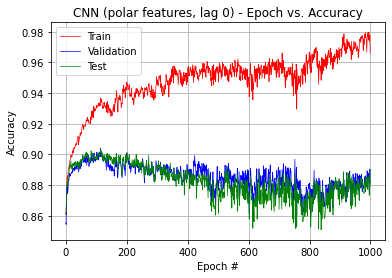

In [59]:
epochs = np.arange(0,num_epochs,1)

plt.plot(epochs, train, c="r", lw=0.7, label="Train")
plt.plot(epochs, val, c="b", lw=0.7, label="Validation")
plt.plot(epochs, test, c="g", lw=0.7, label="Test")
plt.grid(True)
plt.legend(loc="upper left")
plt.title("CNN (polar features, lag 0) - Epoch vs. Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch #")

## CORE ML

## ONNX

In [67]:
import onnx

In [68]:
cnn.eval()
dummy_input = torch.randn(1, 1, 28, 28)
input_names = [ "actual_input" ]
output_names = [ "output" ]
model = cnn

In [69]:
torch.onnx.export(model, 
                  dummy_input,
                  "polar-window10-lag0-cnn.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

# LSTM

In [62]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 2
batch_size = 128
num_epochs = 1000
learning_rate = 0.01

In [63]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [64]:
epochs = {}

In [67]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_iterator)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_iterator):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            epochs[epoch] = {"loss": loss.item(), "train": eval_rnn(model, train_iterator), 
                             "val": eval_rnn(model, val_iterator), "test": eval_rnn(model, test_iterator)}
            
            model.train()

Epoch [1/1000], Step [100/137], Loss: 0.4103
Accuracy of the model on the 17505 samples: 86.12967723507569 %
Accuracy of the model on the 5835 samples: 85.48414738646102 %
Accuracy of the model on the 5835 samples: 86.0325621251071 %
Epoch [2/1000], Step [100/137], Loss: 0.3699
Accuracy of the model on the 17505 samples: 86.48957440731219 %
Accuracy of the model on the 5835 samples: 85.80976863753213 %
Accuracy of the model on the 5835 samples: 86.54670094258783 %
Epoch [3/1000], Step [100/137], Loss: 0.3612
Accuracy of the model on the 17505 samples: 86.77520708369038 %
Accuracy of the model on the 5835 samples: 86.37532133676092 %
Accuracy of the model on the 5835 samples: 86.40959725792631 %
Epoch [4/1000], Step [100/137], Loss: 0.3725
Accuracy of the model on the 17505 samples: 87.20365609825764 %
Accuracy of the model on the 5835 samples: 86.75235646958012 %
Accuracy of the model on the 5835 samples: 87.09511568123393 %
Epoch [5/1000], Step [100/137], Loss: 0.3542
Accuracy of the 

Epoch [36/1000], Step [100/137], Loss: 0.2598
Accuracy of the model on the 17505 samples: 89.26021136818052 %
Accuracy of the model on the 5835 samples: 88.22622107969151 %
Accuracy of the model on the 5835 samples: 88.65467009425878 %
Epoch [37/1000], Step [100/137], Loss: 0.2554
Accuracy of the model on the 17505 samples: 89.2316481005427 %
Accuracy of the model on the 5835 samples: 88.2604970008569 %
Accuracy of the model on the 5835 samples: 88.75749785775493 %
Epoch [38/1000], Step [100/137], Loss: 0.2593
Accuracy of the model on the 17505 samples: 89.31733790345615 %
Accuracy of the model on the 5835 samples: 88.0719794344473 %
Accuracy of the model on the 5835 samples: 88.94601542416453 %
Epoch [39/1000], Step [100/137], Loss: 0.2380
Accuracy of the model on the 17505 samples: 89.55726935161383 %
Accuracy of the model on the 5835 samples: 88.4490145672665 %
Accuracy of the model on the 5835 samples: 89.11739502999143 %
Epoch [40/1000], Step [100/137], Loss: 0.2490
Accuracy of th

Epoch [71/1000], Step [100/137], Loss: 0.2156
Accuracy of the model on the 17505 samples: 90.41416738074835 %
Accuracy of the model on the 5835 samples: 89.22022279348758 %
Accuracy of the model on the 5835 samples: 89.44301628106255 %
Epoch [72/1000], Step [100/137], Loss: 0.2186
Accuracy of the model on the 17505 samples: 90.49414453013425 %
Accuracy of the model on the 5835 samples: 89.30591259640103 %
Accuracy of the model on the 5835 samples: 89.61439588688945 %
Epoch [73/1000], Step [100/137], Loss: 0.2123
Accuracy of the model on the 17505 samples: 90.04284490145673 %
Accuracy of the model on the 5835 samples: 88.75749785775493 %
Accuracy of the model on the 5835 samples: 89.28877463581834 %
Epoch [74/1000], Step [100/137], Loss: 0.2012
Accuracy of the model on the 17505 samples: 90.60268494715795 %
Accuracy of the model on the 5835 samples: 89.44301628106255 %
Accuracy of the model on the 5835 samples: 89.63153384747216 %
Epoch [75/1000], Step [100/137], Loss: 0.2148
Accuracy o

Epoch [106/1000], Step [100/137], Loss: 0.2044
Accuracy of the model on the 17505 samples: 91.07683518994573 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Epoch [107/1000], Step [100/137], Loss: 0.2063
Accuracy of the model on the 17505 samples: 90.57412167952013 %
Accuracy of the model on the 5835 samples: 89.20308483290488 %
Accuracy of the model on the 5835 samples: 89.42587832047987 %
Epoch [108/1000], Step [100/137], Loss: 0.2309
Accuracy of the model on the 17505 samples: 90.31133961725222 %
Accuracy of the model on the 5835 samples: 89.39160239931448 %
Accuracy of the model on the 5835 samples: 89.528706083976 %
Epoch [109/1000], Step [100/137], Loss: 0.1869
Accuracy of the model on the 17505 samples: 91.20251356755213 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Accuracy of the model on the 5835 samples: 89.85432733504713 %
Epoch [110/1000], Step [100/137], Loss: 0.2120
Accuracy 

Epoch [141/1000], Step [100/137], Loss: 0.1719
Accuracy of the model on the 17505 samples: 91.819480148529 %
Accuracy of the model on the 5835 samples: 89.85432733504713 %
Accuracy of the model on the 5835 samples: 89.95715509854327 %
Epoch [142/1000], Step [100/137], Loss: 0.1860
Accuracy of the model on the 17505 samples: 91.84233076263925 %
Accuracy of the model on the 5835 samples: 90.02570694087403 %
Accuracy of the model on the 5835 samples: 90.12853470437018 %
Epoch [143/1000], Step [100/137], Loss: 0.1915
Accuracy of the model on the 17505 samples: 91.71093973150528 %
Accuracy of the model on the 5835 samples: 89.80291345329906 %
Accuracy of the model on the 5835 samples: 89.9228791773779 %
Epoch [144/1000], Step [100/137], Loss: 0.1638
Accuracy of the model on the 17505 samples: 91.4253070551271 %
Accuracy of the model on the 5835 samples: 89.9228791773779 %
Accuracy of the model on the 5835 samples: 90.4370179948586 %
Epoch [145/1000], Step [100/137], Loss: 0.1680
Accuracy of

Epoch [176/1000], Step [100/137], Loss: 0.1701
Accuracy of the model on the 17505 samples: 92.07083690374179 %
Accuracy of the model on the 5835 samples: 89.59725792630677 %
Accuracy of the model on the 5835 samples: 89.99143101970866 %
Epoch [177/1000], Step [100/137], Loss: 0.1571
Accuracy of the model on the 17505 samples: 92.63067694944301 %
Accuracy of the model on the 5835 samples: 89.78577549271637 %
Accuracy of the model on the 5835 samples: 90.19708654670094 %
Epoch [178/1000], Step [100/137], Loss: 0.1659
Accuracy of the model on the 17505 samples: 92.49928591830906 %
Accuracy of the model on the 5835 samples: 90.0771208226221 %
Accuracy of the model on the 5835 samples: 90.35132819194516 %
Epoch [179/1000], Step [100/137], Loss: 0.1847
Accuracy of the model on the 17505 samples: 91.96229648671807 %
Accuracy of the model on the 5835 samples: 89.66580976863753 %
Accuracy of the model on the 5835 samples: 89.94001713796058 %
Epoch [180/1000], Step [100/137], Loss: 0.2033
Accura

Epoch [211/1000], Step [100/137], Loss: 0.2990
Accuracy of the model on the 17505 samples: 88.52327906312482 %
Accuracy of the model on the 5835 samples: 87.76349614395887 %
Accuracy of the model on the 5835 samples: 87.98628963153385 %
Epoch [212/1000], Step [100/137], Loss: 0.2711
Accuracy of the model on the 17505 samples: 89.04884318766067 %
Accuracy of the model on the 5835 samples: 88.32904884318766 %
Accuracy of the model on the 5835 samples: 88.4318766066838 %
Epoch [213/1000], Step [100/137], Loss: 0.2651
Accuracy of the model on the 17505 samples: 89.12882033704656 %
Accuracy of the model on the 5835 samples: 88.24335904027421 %
Accuracy of the model on the 5835 samples: 88.53470437017995 %
Epoch [214/1000], Step [100/137], Loss: 0.2607
Accuracy of the model on the 17505 samples: 89.43159097400742 %
Accuracy of the model on the 5835 samples: 88.51756640959726 %
Accuracy of the model on the 5835 samples: 88.60325621251071 %
Epoch [215/1000], Step [100/137], Loss: 0.2442
Accura

Epoch [246/1000], Step [100/137], Loss: 0.1819
Accuracy of the model on the 17505 samples: 91.2082262210797 %
Accuracy of the model on the 5835 samples: 89.37446443873179 %
Accuracy of the model on the 5835 samples: 89.85432733504713 %
Epoch [247/1000], Step [100/137], Loss: 0.1719
Accuracy of the model on the 17505 samples: 91.40245644101685 %
Accuracy of the model on the 5835 samples: 89.32305055698372 %
Accuracy of the model on the 5835 samples: 89.66580976863753 %
Epoch [248/1000], Step [100/137], Loss: 0.1922
Accuracy of the model on the 17505 samples: 90.88831762353614 %
Accuracy of the model on the 5835 samples: 89.23736075407027 %
Accuracy of the model on the 5835 samples: 89.73436161096829 %
Epoch [249/1000], Step [100/137], Loss: 0.1957
Accuracy of the model on the 17505 samples: 91.28820337046558 %
Accuracy of the model on the 5835 samples: 89.39160239931448 %
Accuracy of the model on the 5835 samples: 90.16281062553556 %
Epoch [250/1000], Step [100/137], Loss: 0.1807
Accura

Epoch [281/1000], Step [100/137], Loss: 0.1888
Accuracy of the model on the 17505 samples: 92.26506712367895 %
Accuracy of the model on the 5835 samples: 89.8886032562125 %
Accuracy of the model on the 5835 samples: 90.04284490145673 %
Epoch [282/1000], Step [100/137], Loss: 0.1845
Accuracy of the model on the 17505 samples: 92.35646958011996 %
Accuracy of the model on the 5835 samples: 89.528706083976 %
Accuracy of the model on the 5835 samples: 90.24850042844902 %
Epoch [283/1000], Step [100/137], Loss: 0.1705
Accuracy of the model on the 17505 samples: 92.26506712367895 %
Accuracy of the model on the 5835 samples: 89.70008568980292 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Epoch [284/1000], Step [100/137], Loss: 0.1726
Accuracy of the model on the 17505 samples: 92.4764353041988 %
Accuracy of the model on the 5835 samples: 89.8886032562125 %
Accuracy of the model on the 5835 samples: 90.05998286203942 %
Epoch [285/1000], Step [100/137], Loss: 0.1660
Accuracy o

Epoch [316/1000], Step [100/137], Loss: 0.1474
Accuracy of the model on the 17505 samples: 92.9163096258212 %
Accuracy of the model on the 5835 samples: 89.87146529562982 %
Accuracy of the model on the 5835 samples: 90.17994858611826 %
Epoch [317/1000], Step [100/137], Loss: 0.1685
Accuracy of the model on the 17505 samples: 93.06483861753784 %
Accuracy of the model on the 5835 samples: 89.95715509854327 %
Accuracy of the model on the 5835 samples: 90.55698371893745 %
Epoch [318/1000], Step [100/137], Loss: 0.1816
Accuracy of the model on the 17505 samples: 92.88203370465581 %
Accuracy of the model on the 5835 samples: 90.00856898029134 %
Accuracy of the model on the 5835 samples: 90.26563838903171 %
Epoch [319/1000], Step [100/137], Loss: 0.1741
Accuracy of the model on the 17505 samples: 92.96201085404171 %
Accuracy of the model on the 5835 samples: 89.99143101970866 %
Accuracy of the model on the 5835 samples: 90.38560411311055 %
Epoch [320/1000], Step [100/137], Loss: 0.1540
Accura

Epoch [351/1000], Step [100/137], Loss: 0.1700
Accuracy of the model on the 17505 samples: 91.43673236218223 %
Accuracy of the model on the 5835 samples: 89.64867180805484 %
Accuracy of the model on the 5835 samples: 89.75149957155098 %
Epoch [352/1000], Step [100/137], Loss: 0.1736
Accuracy of the model on the 17505 samples: 93.25906883747501 %
Accuracy of the model on the 5835 samples: 89.9057412167952 %
Accuracy of the model on the 5835 samples: 90.31705227077978 %
Epoch [353/1000], Step [100/137], Loss: 0.1541
Accuracy of the model on the 17505 samples: 93.47614967152242 %
Accuracy of the model on the 5835 samples: 90.21422450728363 %
Accuracy of the model on the 5835 samples: 90.67694944301628 %
Epoch [354/1000], Step [100/137], Loss: 0.1637
Accuracy of the model on the 17505 samples: 93.11053984575835 %
Accuracy of the model on the 5835 samples: 90.12853470437018 %
Accuracy of the model on the 5835 samples: 89.95715509854327 %
Epoch [355/1000], Step [100/137], Loss: 0.1546
Accura

Epoch [386/1000], Step [100/137], Loss: 0.2231
Accuracy of the model on the 17505 samples: 92.32219365895459 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Accuracy of the model on the 5835 samples: 90.26563838903171 %
Epoch [387/1000], Step [100/137], Loss: 0.2329
Accuracy of the model on the 17505 samples: 92.17366466723793 %
Accuracy of the model on the 5835 samples: 89.66580976863753 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Epoch [388/1000], Step [100/137], Loss: 0.2225
Accuracy of the model on the 17505 samples: 91.66523850328477 %
Accuracy of the model on the 5835 samples: 89.3573264781491 %
Accuracy of the model on the 5835 samples: 89.528706083976 %
Epoch [389/1000], Step [100/137], Loss: 0.1913
Accuracy of the model on the 17505 samples: 92.98486146815196 %
Accuracy of the model on the 5835 samples: 90.21422450728363 %
Accuracy of the model on the 5835 samples: 90.23136246786632 %
Epoch [390/1000], Step [100/137], Loss: 0.1635
Accuracy

Epoch [421/1000], Step [100/137], Loss: 0.1750
Accuracy of the model on the 17505 samples: 92.37932019423022 %
Accuracy of the model on the 5835 samples: 89.75149957155098 %
Accuracy of the model on the 5835 samples: 89.68294772922022 %
Epoch [422/1000], Step [100/137], Loss: 0.1872
Accuracy of the model on the 17505 samples: 93.25335618394745 %
Accuracy of the model on the 5835 samples: 89.8886032562125 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Epoch [423/1000], Step [100/137], Loss: 0.1766
Accuracy of the model on the 17505 samples: 93.83604684375892 %
Accuracy of the model on the 5835 samples: 90.40274207369323 %
Accuracy of the model on the 5835 samples: 90.36846615252784 %
Epoch [424/1000], Step [100/137], Loss: 0.1651
Accuracy of the model on the 17505 samples: 93.4475864038846 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Accuracy of the model on the 5835 samples: 90.35132819194516 %
Epoch [425/1000], Step [100/137], Loss: 0.2064
Accuracy 

Epoch [456/1000], Step [100/137], Loss: 0.2511
Accuracy of the model on the 17505 samples: 89.79720079977149 %
Accuracy of the model on the 5835 samples: 88.4490145672665 %
Accuracy of the model on the 5835 samples: 88.67180805484148 %
Epoch [457/1000], Step [100/137], Loss: 0.2332
Accuracy of the model on the 17505 samples: 89.85432733504713 %
Accuracy of the model on the 5835 samples: 88.9802913453299 %
Accuracy of the model on the 5835 samples: 88.60325621251071 %
Epoch [458/1000], Step [100/137], Loss: 0.2222
Accuracy of the model on the 17505 samples: 90.15138531848044 %
Accuracy of the model on the 5835 samples: 89.03170522707798 %
Accuracy of the model on the 5835 samples: 89.03170522707798 %
Epoch [459/1000], Step [100/137], Loss: 0.2205
Accuracy of the model on the 17505 samples: 90.07140816909454 %
Accuracy of the model on the 5835 samples: 88.87746358183377 %
Accuracy of the model on the 5835 samples: 88.91173950299914 %
Epoch [460/1000], Step [100/137], Loss: 0.2286
Accurac

Epoch [491/1000], Step [100/137], Loss: 0.2058
Accuracy of the model on the 17505 samples: 90.77977720651242 %
Accuracy of the model on the 5835 samples: 89.40874035989717 %
Accuracy of the model on the 5835 samples: 89.1688089117395 %
Epoch [492/1000], Step [100/137], Loss: 0.2166
Accuracy of the model on the 17505 samples: 90.67123678948872 %
Accuracy of the model on the 5835 samples: 89.03170522707798 %
Accuracy of the model on the 5835 samples: 89.3573264781491 %
Epoch [493/1000], Step [100/137], Loss: 0.2208
Accuracy of the model on the 17505 samples: 91.18537560696944 %
Accuracy of the model on the 5835 samples: 89.42587832047987 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Epoch [494/1000], Step [100/137], Loss: 0.2335
Accuracy of the model on the 17505 samples: 91.16252499285919 %
Accuracy of the model on the 5835 samples: 89.3401885175664 %
Accuracy of the model on the 5835 samples: 89.28877463581834 %
Epoch [495/1000], Step [100/137], Loss: 0.2202
Accuracy

Epoch [526/1000], Step [100/137], Loss: 0.1975
Accuracy of the model on the 17505 samples: 91.89945729791488 %
Accuracy of the model on the 5835 samples: 89.94001713796058 %
Accuracy of the model on the 5835 samples: 89.51156812339332 %
Epoch [527/1000], Step [100/137], Loss: 0.2173
Accuracy of the model on the 17505 samples: 90.7683518994573 %
Accuracy of the model on the 5835 samples: 88.2604970008569 %
Accuracy of the model on the 5835 samples: 88.99742930591259 %
Epoch [528/1000], Step [100/137], Loss: 0.1797
Accuracy of the model on the 17505 samples: 90.99685804055984 %
Accuracy of the model on the 5835 samples: 89.75149957155098 %
Accuracy of the model on the 5835 samples: 89.44301628106255 %
Epoch [529/1000], Step [100/137], Loss: 0.2063
Accuracy of the model on the 17505 samples: 91.57954870037132 %
Accuracy of the model on the 5835 samples: 89.51156812339332 %
Accuracy of the model on the 5835 samples: 89.40874035989717 %
Epoch [530/1000], Step [100/137], Loss: 0.1962
Accurac

Epoch [561/1000], Step [100/137], Loss: 0.1865
Accuracy of the model on the 17505 samples: 92.55641245358468 %
Accuracy of the model on the 5835 samples: 89.94001713796058 %
Accuracy of the model on the 5835 samples: 89.3573264781491 %
Epoch [562/1000], Step [100/137], Loss: 0.1736
Accuracy of the model on the 17505 samples: 92.18508997429306 %
Accuracy of the model on the 5835 samples: 89.66580976863753 %
Accuracy of the model on the 5835 samples: 89.70008568980292 %
Epoch [563/1000], Step [100/137], Loss: 0.2497
Accuracy of the model on the 17505 samples: 92.10511282490717 %
Accuracy of the model on the 5835 samples: 89.58011996572408 %
Accuracy of the model on the 5835 samples: 89.30591259640103 %
Epoch [564/1000], Step [100/137], Loss: 0.2060
Accuracy of the model on the 17505 samples: 92.15652670665524 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Accuracy of the model on the 5835 samples: 89.3401885175664 %
Epoch [565/1000], Step [100/137], Loss: 0.1616
Accurac

Epoch [596/1000], Step [100/137], Loss: 0.2789
Accuracy of the model on the 17505 samples: 88.84318766066838 %
Accuracy of the model on the 5835 samples: 88.00342759211654 %
Accuracy of the model on the 5835 samples: 87.86632390745501 %
Epoch [597/1000], Step [100/137], Loss: 0.3140
Accuracy of the model on the 17505 samples: 88.84318766066838 %
Accuracy of the model on the 5835 samples: 87.74635818337617 %
Accuracy of the model on the 5835 samples: 88.05484147386461 %
Epoch [598/1000], Step [100/137], Loss: 0.2474
Accuracy of the model on the 17505 samples: 89.84861468151956 %
Accuracy of the model on the 5835 samples: 88.74035989717224 %
Accuracy of the model on the 5835 samples: 88.6203941730934 %
Epoch [599/1000], Step [100/137], Loss: 0.2208
Accuracy of the model on the 17505 samples: 90.48843187660668 %
Accuracy of the model on the 5835 samples: 88.82604970008569 %
Accuracy of the model on the 5835 samples: 89.25449871465295 %
Epoch [600/1000], Step [100/137], Loss: 0.2134
Accura

Epoch [631/1000], Step [100/137], Loss: 0.1892
Accuracy of the model on the 17505 samples: 92.6192516423879 %
Accuracy of the model on the 5835 samples: 89.99143101970866 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Epoch [632/1000], Step [100/137], Loss: 0.1817
Accuracy of the model on the 17505 samples: 92.63067694944301 %
Accuracy of the model on the 5835 samples: 89.87146529562982 %
Accuracy of the model on the 5835 samples: 89.70008568980292 %
Epoch [633/1000], Step [100/137], Loss: 0.1694
Accuracy of the model on the 17505 samples: 92.76778063410454 %
Accuracy of the model on the 5835 samples: 89.82005141388174 %
Accuracy of the model on the 5835 samples: 89.80291345329906 %
Epoch [634/1000], Step [100/137], Loss: 0.1564
Accuracy of the model on the 17505 samples: 93.05912596401028 %
Accuracy of the model on the 5835 samples: 89.97429305912597 %
Accuracy of the model on the 5835 samples: 90.35132819194516 %
Epoch [635/1000], Step [100/137], Loss: 0.1659
Accura

Epoch [666/1000], Step [100/137], Loss: 0.1751
Accuracy of the model on the 17505 samples: 93.23050556983719 %
Accuracy of the model on the 5835 samples: 89.78577549271637 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Epoch [667/1000], Step [100/137], Loss: 0.1841
Accuracy of the model on the 17505 samples: 92.57355041416739 %
Accuracy of the model on the 5835 samples: 89.95715509854327 %
Accuracy of the model on the 5835 samples: 89.40874035989717 %
Epoch [668/1000], Step [100/137], Loss: 0.1744
Accuracy of the model on the 17505 samples: 93.01342473578977 %
Accuracy of the model on the 5835 samples: 89.9228791773779 %
Accuracy of the model on the 5835 samples: 89.63153384747216 %
Epoch [669/1000], Step [100/137], Loss: 0.1682
Accuracy of the model on the 17505 samples: 92.77920594115967 %
Accuracy of the model on the 5835 samples: 89.51156812339332 %
Accuracy of the model on the 5835 samples: 89.3401885175664 %
Epoch [670/1000], Step [100/137], Loss: 0.1619
Accurac

Epoch [701/1000], Step [100/137], Loss: 0.1483
Accuracy of the model on the 17505 samples: 93.45901171093973 %
Accuracy of the model on the 5835 samples: 89.95715509854327 %
Accuracy of the model on the 5835 samples: 89.58011996572408 %
Epoch [702/1000], Step [100/137], Loss: 0.1436
Accuracy of the model on the 17505 samples: 93.59040274207369 %
Accuracy of the model on the 5835 samples: 89.99143101970866 %
Accuracy of the model on the 5835 samples: 90.00856898029134 %
Epoch [703/1000], Step [100/137], Loss: 0.1655
Accuracy of the model on the 17505 samples: 92.12225078548985 %
Accuracy of the model on the 5835 samples: 89.10025706940874 %
Accuracy of the model on the 5835 samples: 88.94601542416453 %
Epoch [704/1000], Step [100/137], Loss: 0.1726
Accuracy of the model on the 17505 samples: 92.25364181662383 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Accuracy of the model on the 5835 samples: 89.15167095115682 %
Epoch [705/1000], Step [100/137], Loss: 0.1835
Accur

Epoch [736/1000], Step [100/137], Loss: 0.3557
Accuracy of the model on the 17505 samples: 89.13453299057412 %
Accuracy of the model on the 5835 samples: 87.7120822622108 %
Accuracy of the model on the 5835 samples: 87.30077120822622 %
Epoch [737/1000], Step [100/137], Loss: 0.1729
Accuracy of the model on the 17505 samples: 92.39074550128535 %
Accuracy of the model on the 5835 samples: 89.37446443873179 %
Accuracy of the model on the 5835 samples: 89.46015424164524 %
Epoch [738/1000], Step [100/137], Loss: 0.1645
Accuracy of the model on the 17505 samples: 93.29905741216795 %
Accuracy of the model on the 5835 samples: 89.9228791773779 %
Accuracy of the model on the 5835 samples: 90.0942587832048 %
Epoch [739/1000], Step [100/137], Loss: 0.1629
Accuracy of the model on the 17505 samples: 92.53356183947443 %
Accuracy of the model on the 5835 samples: 89.49443016281063 %
Accuracy of the model on the 5835 samples: 89.51156812339332 %
Epoch [740/1000], Step [100/137], Loss: 0.2056
Accuracy

Epoch [771/1000], Step [100/137], Loss: 0.3583
Accuracy of the model on the 17505 samples: 88.20337046558126 %
Accuracy of the model on the 5835 samples: 87.40359897172236 %
Accuracy of the model on the 5835 samples: 87.48928877463582 %
Epoch [772/1000], Step [100/137], Loss: 0.3317
Accuracy of the model on the 17505 samples: 89.02027992002284 %
Accuracy of the model on the 5835 samples: 87.62639245929735 %
Accuracy of the model on the 5835 samples: 88.46615252784919 %
Epoch [773/1000], Step [100/137], Loss: 0.2886
Accuracy of the model on the 17505 samples: 89.6086832333619 %
Accuracy of the model on the 5835 samples: 88.58611825192801 %
Accuracy of the model on the 5835 samples: 88.67180805484148 %
Epoch [774/1000], Step [100/137], Loss: 0.3001
Accuracy of the model on the 17505 samples: 90.21422450728363 %
Accuracy of the model on the 5835 samples: 88.7917737789203 %
Accuracy of the model on the 5835 samples: 88.91173950299914 %
Epoch [775/1000], Step [100/137], Loss: 0.2974
Accurac

Epoch [806/1000], Step [100/137], Loss: 0.2951
Accuracy of the model on the 17505 samples: 89.70579834333047 %
Accuracy of the model on the 5835 samples: 88.63753213367609 %
Accuracy of the model on the 5835 samples: 88.77463581833761 %
Epoch [807/1000], Step [100/137], Loss: 0.2403
Accuracy of the model on the 17505 samples: 90.29991431019708 %
Accuracy of the model on the 5835 samples: 88.7917737789203 %
Accuracy of the model on the 5835 samples: 89.06598114824335 %
Epoch [808/1000], Step [100/137], Loss: 0.2389
Accuracy of the model on the 17505 samples: 90.5169951442445 %
Accuracy of the model on the 5835 samples: 89.20308483290488 %
Accuracy of the model on the 5835 samples: 89.10025706940874 %
Epoch [809/1000], Step [100/137], Loss: 0.2348
Accuracy of the model on the 17505 samples: 90.59125964010283 %
Accuracy of the model on the 5835 samples: 89.32305055698372 %
Accuracy of the model on the 5835 samples: 88.9802913453299 %
Epoch [810/1000], Step [100/137], Loss: 0.2374
Accuracy

Epoch [841/1000], Step [100/137], Loss: 0.2043
Accuracy of the model on the 17505 samples: 91.69380177092259 %
Accuracy of the model on the 5835 samples: 89.73436161096829 %
Accuracy of the model on the 5835 samples: 90.0771208226221 %
Epoch [842/1000], Step [100/137], Loss: 0.2050
Accuracy of the model on the 17505 samples: 91.61382462153671 %
Accuracy of the model on the 5835 samples: 89.13453299057412 %
Accuracy of the model on the 5835 samples: 89.37446443873179 %
Epoch [843/1000], Step [100/137], Loss: 0.2102
Accuracy of the model on the 17505 samples: 91.819480148529 %
Accuracy of the model on the 5835 samples: 89.47729220222793 %
Accuracy of the model on the 5835 samples: 89.39160239931448 %
Epoch [844/1000], Step [100/137], Loss: 0.2299
Accuracy of the model on the 17505 samples: 91.85946872322194 %
Accuracy of the model on the 5835 samples: 89.42587832047987 %
Accuracy of the model on the 5835 samples: 89.8886032562125 %
Epoch [845/1000], Step [100/137], Loss: 0.3795
Accuracy 

Epoch [876/1000], Step [100/137], Loss: 0.1947
Accuracy of the model on the 17505 samples: 91.85946872322194 %
Accuracy of the model on the 5835 samples: 89.68294772922022 %
Accuracy of the model on the 5835 samples: 90.14567266495287 %
Epoch [877/1000], Step [100/137], Loss: 0.1979
Accuracy of the model on the 17505 samples: 91.73379034561553 %
Accuracy of the model on the 5835 samples: 89.7172236503856 %
Accuracy of the model on the 5835 samples: 89.63153384747216 %
Epoch [878/1000], Step [100/137], Loss: 0.2176
Accuracy of the model on the 17505 samples: 91.22536418166239 %
Accuracy of the model on the 5835 samples: 89.15167095115682 %
Accuracy of the model on the 5835 samples: 89.28877463581834 %
Epoch [879/1000], Step [100/137], Loss: 0.2050
Accuracy of the model on the 17505 samples: 91.64238788917451 %
Accuracy of the model on the 5835 samples: 89.83718937446444 %
Accuracy of the model on the 5835 samples: 89.85432733504713 %
Epoch [880/1000], Step [100/137], Loss: 0.1881
Accura

Epoch [911/1000], Step [100/137], Loss: 0.2923
Accuracy of the model on the 17505 samples: 88.77463581833761 %
Accuracy of the model on the 5835 samples: 87.67780634104541 %
Accuracy of the model on the 5835 samples: 88.24335904027421 %
Epoch [912/1000], Step [100/137], Loss: 0.2912
Accuracy of the model on the 17505 samples: 89.14024564410168 %
Accuracy of the model on the 5835 samples: 88.53470437017995 %
Accuracy of the model on the 5835 samples: 88.36332476435304 %
Epoch [913/1000], Step [100/137], Loss: 0.2841
Accuracy of the model on the 17505 samples: 89.22022279348758 %
Accuracy of the model on the 5835 samples: 88.38046272493574 %
Accuracy of the model on the 5835 samples: 88.32904884318766 %
Epoch [914/1000], Step [100/137], Loss: 0.2765
Accuracy of the model on the 17505 samples: 89.26021136818052 %
Accuracy of the model on the 5835 samples: 88.65467009425878 %
Accuracy of the model on the 5835 samples: 88.36332476435304 %
Epoch [915/1000], Step [100/137], Loss: 0.2811
Accur

Epoch [946/1000], Step [100/137], Loss: 0.2919
Accuracy of the model on the 17505 samples: 88.9345901171094 %
Accuracy of the model on the 5835 samples: 88.38046272493574 %
Accuracy of the model on the 5835 samples: 88.4490145672665 %
Epoch [947/1000], Step [100/137], Loss: 0.2923
Accuracy of the model on the 17505 samples: 89.0431305341331 %
Accuracy of the model on the 5835 samples: 88.38046272493574 %
Accuracy of the model on the 5835 samples: 88.39760068551843 %
Epoch [948/1000], Step [100/137], Loss: 0.2988
Accuracy of the model on the 17505 samples: 88.86603827477863 %
Accuracy of the model on the 5835 samples: 88.31191088260498 %
Accuracy of the model on the 5835 samples: 88.20908311910883 %
Epoch [949/1000], Step [100/137], Loss: 0.2938
Accuracy of the model on the 17505 samples: 89.26592402170809 %
Accuracy of the model on the 5835 samples: 88.31191088260498 %
Accuracy of the model on the 5835 samples: 88.41473864610111 %
Epoch [950/1000], Step [100/137], Loss: 0.2815
Accuracy

Epoch [981/1000], Step [100/137], Loss: 0.2693
Accuracy of the model on the 17505 samples: 88.55184233076264 %
Accuracy of the model on the 5835 samples: 87.5235646958012 %
Accuracy of the model on the 5835 samples: 87.83204798628964 %
Epoch [982/1000], Step [100/137], Loss: 0.2650
Accuracy of the model on the 17505 samples: 88.92316481005427 %
Accuracy of the model on the 5835 samples: 88.03770351328193 %
Accuracy of the model on the 5835 samples: 88.17480719794345 %
Epoch [983/1000], Step [100/137], Loss: 0.2629
Accuracy of the model on the 17505 samples: 88.97457869180234 %
Accuracy of the model on the 5835 samples: 88.15766923736075 %
Accuracy of the model on the 5835 samples: 88.0719794344473 %
Epoch [984/1000], Step [100/137], Loss: 0.2583
Accuracy of the model on the 17505 samples: 89.01456726649529 %
Accuracy of the model on the 5835 samples: 88.4318766066838 %
Accuracy of the model on the 5835 samples: 88.48329048843188 %
Epoch [985/1000], Step [100/137], Loss: 0.2626
Accuracy

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_iterator:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Val Accuracy of the model on the {len(y_val)} val images: {100 * correct / total} %') 
            
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_iterator:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy of the model on the {len(y_test)} test images: {100 * correct / total} %') 

In [75]:
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [76]:
from torchviz import make_dot

dum_input = torch.ones(1,28,28).to(device)
a = model(dum_input)
make_dot(a, params=dict(model.named_parameters())).render(f"{save_dir}viz/lstm-{num_epochs}epochs-{num_layers}layers-{hidden_size}hidden",format="png")

'/home/hwixley/Documents/4th-Year/Honours-Project/localhost-data-preprocessing/ml-models/polar-lag0/viz/lstm-20epochs-2layers-128hidden.png'

In [68]:
train_rnn = []
val_rnn = []
test_rnn = []
loss_rnn = []

for i in range(num_epochs):
    ep = epochs[i]
    train_rnn.append(ep["train"][2])
    val_rnn.append(ep["val"][2])
    test_rnn.append(ep["test"][2])
    loss_rnn.append(ep["loss"])

Text(0.5, 0, 'Epoch #')

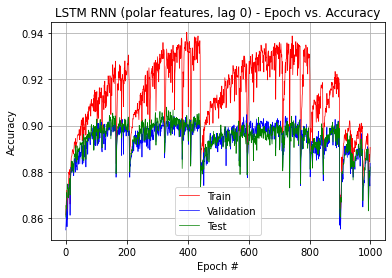

In [75]:
epochs = np.arange(0,num_epochs,1)

plt.plot(epochs, train_rnn, c="r", lw=0.7, label="Train")
plt.plot(epochs, val_rnn, c="b", lw=0.7, label="Validation")
plt.plot(epochs, test_rnn, c="g", lw=0.7, label="Test")
plt.grid(True)
plt.legend(loc="lower center")
plt.title("LSTM RNN (polar features, lag 0) - Epoch vs. Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch #")

In [41]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [69]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [114]:
vgg11_config = [6, 'M', 12, 'M', 24, 24, 'M']#[64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

In [115]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [116]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [117]:
OUTPUT_DIM = 2

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2

## TRAINING

In [118]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [119]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in
                self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [120]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

RuntimeError: Given input size: (12x1x1). Calculated output size: (12x0x0). Output size is too small